# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

## **Import**

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import wandb
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt

#import models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Import PyTorch and Torchvion
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models.resnet import BasicBlock

#import Datasets
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100


### ***Further settings***

In [2]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fix random seed for reproducibility
torch.manual_seed(808)

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

# *Exercise 1.1: A baseline MLP*

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

###  **Model architecure**

In [11]:
# Model with 2 hidden layer 
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size,dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout = nn.Dropout(p=dropout_rate)  
        self.out = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)          
        return self.out(x)


### **Data preparation**

In [3]:

# Data parameters
batch_size = 128
val_fraction=0.1

# Load the MNIST dataset with standard normalization, and split the training set into training and validation subsets
def load_mnist_datasets(data_dir='./data', val_fraction=val_fraction, download=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_dataset = MNIST(root=data_dir, train=True, download=download, transform=transform)
    test = MNIST(root=data_dir, train=False, download=download, transform=transform)

    total_train = len(full_dataset)
    val_size = int(total_train * val_fraction)
    train_size = total_train - val_size

    train, val = torch.utils.data.random_split(full_dataset, [train_size, val_size]) 
    # Create DataLoaders
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = load_mnist_datasets()


## **TRANING CONFIGURATION**

In [4]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device,
                patience, min_delta,
                delta_overfit, overfit_patience,
                wandb_project=None, wandb_run_name=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Device: {device}")

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    overfit_epochs = 0
    insufficient_change_epochs = 0
    prev_val_loss = None
    actual_epochs = num_epochs  # Default: all epochs completed

    # Initialize Weights & Biases
    if wandb_project is not None:
        wandb.init(project=wandb_project, name=wandb_run_name, reinit=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss, val_acc = 0, 0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
            val_loss /= val_total
            val_acc = val_correct / val_total
            val_losses.append(val_loss)

        # Print training progress
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.4f}")
        print(f"  Val_Loss: {val_loss:.4f} | Val_Acc: {val_acc:.4f}\n")

        # Log metrics to wandb
        if wandb_project is not None:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

        # Save best model and reset overfitting counter
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            overfit_epochs = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            # If validation loss increases, count as potential overfitting
            if val_loss > best_val_loss + delta_overfit:
                overfit_epochs += 1
                print(f"⚠️WARNING:Change in the trend of value  val_loss: best value= {best_val_loss:.4f} | current value= {val_loss:.4f}")
                if overfit_epochs >= overfit_patience: 
                    print(f"🛑Early stopping due to high risk of OVERFITTING\nEpoch {epoch+1}: val_loss is INCREASING for {overfit_patience} epochs")
                    actual_epochs = epoch + 1
                    break
            else:
                overfit_epochs = 0

        # Check for stagnation
        if prev_val_loss is None:
            prev_val_loss = val_loss
            continue

        delta = abs(prev_val_loss - val_loss)
        if delta >= min_delta:
            insufficient_change_epochs = 0
        else:
            insufficient_change_epochs += 1
            print(f"⚠️Δ(val_loss) < {min_delta} for {insufficient_change_epochs} consecutive epoch(s)")
            if insufficient_change_epochs >= patience:
                print(f"🛑Early stopping due to STAGNATION\nEpoch {epoch+1}: No significant change (|Δ| < {min_delta}) for {patience} consecutive epochs.")
                actual_epochs = epoch + 1
                break

        prev_val_loss = val_loss

    if wandb_project is not None:
        wandb.finish()

    return train_losses, val_losses, actual_epochs


### **Evaluation configuration**

In [5]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision


## ***Model Traning*** 

In [12]:
# Hyperparameters of a standard MLP
input_size = 28 * 28
hidden_size1 = 128
hidden_size2 = 64
output_size = 10
dropout_rate = 0.2
num_epochs = 50
learning_rate = 0.001

# Parameters for early stopping and overfitting detection
patience = 5
min_delta = 0.001
delta_overfit = 0.01
overfit_patience = 5

# WandB configuration
wandb_project = None
wandb_run_name = None

# Creation and traning of MLP
mlp_model = MLP(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, mlp_epoch = train_model(
    mlp_model, train_loader, val_loader, mlp_optimizer, criterion, num_epochs, device,
    patience, min_delta, delta_overfit, overfit_patience,
    wandb_project="AML_MLP", wandb_run_name="2lp_run"
)


Device: cuda


Epoch 1/50
  Train_Loss: 0.3816 | Train_Acc: 0.8876
  Val_Loss: 0.1663 | Val_Acc: 0.9478

Epoch 2/50
  Train_Loss: 0.1600 | Train_Acc: 0.9523
  Val_Loss: 0.1254 | Val_Acc: 0.9595

Epoch 3/50
  Train_Loss: 0.1132 | Train_Acc: 0.9659
  Val_Loss: 0.1002 | Val_Acc: 0.9687

Epoch 4/50
  Train_Loss: 0.0872 | Train_Acc: 0.9737
  Val_Loss: 0.0928 | Val_Acc: 0.9695

Epoch 5/50
  Train_Loss: 0.0709 | Train_Acc: 0.9782
  Val_Loss: 0.0891 | Val_Acc: 0.9710

Epoch 6/50
  Train_Loss: 0.0599 | Train_Acc: 0.9811
  Val_Loss: 0.0770 | Val_Acc: 0.9742

Epoch 7/50
  Train_Loss: 0.0500 | Train_Acc: 0.9838
  Val_Loss: 0.0788 | Val_Acc: 0.9763

Epoch 8/50
  Train_Loss: 0.0427 | Train_Acc: 0.9861
  Val_Loss: 0.0825 | Val_Acc: 0.9740

Epoch 9/50
  Train_Loss: 0.0399 | Train_Acc: 0.9866
  Val_Loss: 0.0760 | Val_Acc: 0.9783

Epoch 10/50
  Train_Loss: 0.0329 | Train_Acc: 0.9895
  Val_Loss: 0.0780 | Val_Acc: 0.9777

Epoch 11/50
  Train_Loss: 0.0300 | Train_Acc: 0.9901
  Val_Loss: 0.0779 | Val_Acc: 0.9792

⚠️Δ(val_

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_acc,▁▅▆▇▇▇▇██████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▆▇▇▇████▇▇▇▇█
val_loss,█▅▃▂▂▁▁▂▁▁▁▁▂▂▂▂▂
epoch,17
train_acc,0.99306
train_loss,0.01977
val_acc,0.97917
val_loss,0.09414


### **Model Evalation**


--------------------------------------------------------------------------------
Test Loss: 0.0877 | Test Accuracy: 0.9797 | Test Precision: 0.9797
--------------------------------------------------------------------------------



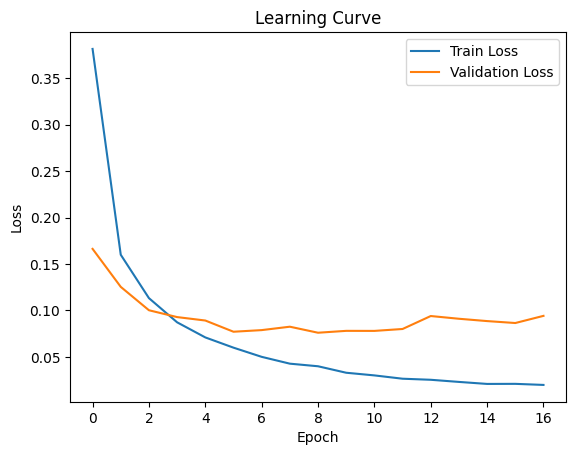

In [13]:
# Evaluation on test set
mlp_test_loss, mlp_test_acc, mlp_precision = evaluate(mlp_model, test_loader, criterion, device)
print(f"\n{'-'*80}")
print(f"Test Loss: {mlp_test_loss:.4f} | Test Accuracy: {mlp_test_acc:.4f} | Test Precision: {mlp_precision:.4f}")
print(f"{'-'*80}\n")

# Plot learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


# *Exercise 1.2: Adding Residual Connections*

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

###  **Model architecure**

In [6]:
# Define a residual block
class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = x
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        out = self.dropout(out)
        out += identity
        out = F.relu(out)
        return out

# Residual MLP with stacked residual blocks
class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_blocks, dropout_rate):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_size, hidden_size, dropout_rate) for _ in range(num_blocks)
        ])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features) 
        x = F.relu(self.fc1(x))
        x = self.blocks(x)
        x = self.fc2(x)
        return x


###    **ResMLP traning**

In [8]:

#  Hyperparameters 
input_size = 28 * 28
output_size=10
hidden_size = 110
num_blocks = 2
dropout_rate = 0.2

# Creation and traning of ResidualMLP
res_model = ResidualMLP(input_size, hidden_size, output_size, num_blocks, dropout_rate)
res_optimizer = torch.optim.Adam(res_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, res_epoch = train_model(
    res_model, train_loader, val_loader, res_optimizer, criterion, num_epochs, device,
    patience, min_delta, delta_overfit, overfit_patience,
    wandb_project="AML_ResMLP", wandb_run_name="ResidualMLP"
)


Device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: emile-agbedanu (emile-agbedanu-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50
  Train_Loss: 0.2812 | Train_Acc: 0.9159
  Val_Loss: 0.1367 | Val_Acc: 0.9565

Epoch 2/50
  Train_Loss: 0.1149 | Train_Acc: 0.9644
  Val_Loss: 0.1185 | Val_Acc: 0.9632

Epoch 3/50
  Train_Loss: 0.0828 | Train_Acc: 0.9745
  Val_Loss: 0.0866 | Val_Acc: 0.9722

Epoch 4/50
  Train_Loss: 0.0635 | Train_Acc: 0.9800
  Val_Loss: 0.0828 | Val_Acc: 0.9750

Epoch 5/50
  Train_Loss: 0.0524 | Train_Acc: 0.9829
  Val_Loss: 0.0879 | Val_Acc: 0.9730

Epoch 6/50
  Train_Loss: 0.0421 | Train_Acc: 0.9864
  Val_Loss: 0.0911 | Val_Acc: 0.9770

Epoch 7/50
  Train_Loss: 0.0396 | Train_Acc: 0.9875
  Val_Loss: 0.0750 | Val_Acc: 0.9783

Epoch 8/50
  Train_Loss: 0.0298 | Train_Acc: 0.9905
  Val_Loss: 0.0878 | Val_Acc: 0.9758

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.0750 | current value= 0.0878
Epoch 9/50
  Train_Loss: 0.0270 | Train_Acc: 0.9909
  Val_Loss: 0.0784 | Val_Acc: 0.9773

Epoch 10/50
  Train_Loss: 0.0275 | Train_Acc: 0.9909
  Val_Loss: 0.0867 | Val_Acc: 0.9760

⚠️WARN

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_acc,▁▅▆▇▇▇▇███████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▆▇▆██▇█▇█▇▇▇
val_loss,█▆▂▂▂▃▁▂▁▂▃▄▃▅
epoch,14
train_acc,0.99339
train_loss,0.01943
val_acc,0.97383
val_loss,0.11359


### **ResMLP evaluation**


--------------------------------------------------------------------------------
Test Loss: 0.0988 | Test Accuracy: 0.9753 | Test Precision: 0.9755
--------------------------------------------------------------------------------



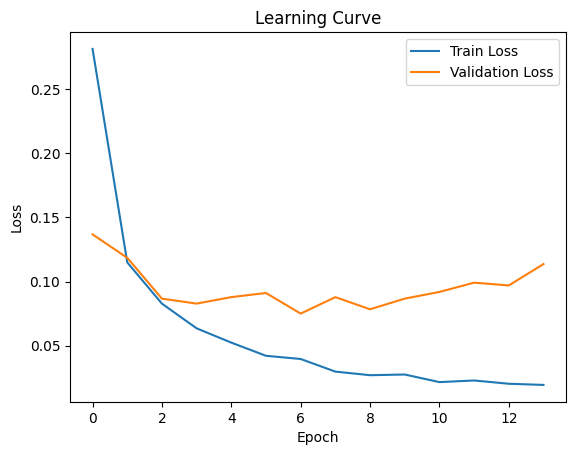

In [9]:
# Evaluation on test set
res_test_loss, res_test_acc, res_precision = evaluate(res_model, test_loader, criterion, device)
print(f"\n{'-'*80}")
print(f"Test Loss: {res_test_loss:.4f} | Test Accuracy: {res_test_acc:.4f} | Test Precision: {res_precision:.4f}")
print(f"{'-'*80}\n")
# Plot learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


### **Comparison Summary**

In [14]:
# Final performance comparison between MLP and ResidualMLP
print("-" * 65)

print(f"{' '*5}{'*'*5} Comparison MLP vs ResidualMLP on TEST SET{'*'*5}")
print("-" * 65)
print(f"{'':<15} | {'Epochs':<7} | {'Loss':<10} | {'Accuracy':<10} | {'Precision':<10}")
print("-" * 65)
print(f"{'MLP':<15} | {mlp_epoch:<7} | {mlp_test_loss:<10.4f} | {mlp_test_acc:<10.4f} | {mlp_precision:<10.4f}")
print(f"{'ResidualMLP':<15} | {res_epoch:<7} | {res_test_loss:<10.4f} | {res_test_acc:<10.4f} | {res_precision:<10.4f}\n")

# Printing of L2 norm of gradients for each layer (MLP) 
print(f"{'*'*4} MLP{'*'*4}\n")
for name, param in mlp_model.named_parameters():
    if param.requires_grad and 'weight' in name:
        print(f"{name} grad norm: {param.grad.norm().item():.4f}")

# Printing of L2 norm of gradients for each layer (ResidualMLP) 
print(f"\n{'*'*4} ResidualMLP{'*'*4}\n")
for name, param in res_model.named_parameters():
    if param.requires_grad and 'weight' in name:
        print(f"{name} grad norm: {param.grad.norm().item():.4f}")


-----------------------------------------------------------------
     ***** Comparison MLP vs ResidualMLP on TEST SET*****
-----------------------------------------------------------------
                | Epochs  | Loss       | Accuracy   | Precision 
-----------------------------------------------------------------
MLP             | 17      | 0.0877     | 0.9797     | 0.9797    
ResidualMLP     | 14      | 0.0988     | 0.9753     | 0.9755    

**** MLP****

fc1.weight grad norm: 0.4399
fc2.weight grad norm: 0.3524
out.weight grad norm: 0.2365

**** ResidualMLP****

fc1.weight grad norm: 0.4189
blocks.0.fc1.weight grad norm: 0.2364
blocks.0.fc2.weight grad norm: 0.1867
blocks.1.fc1.weight grad norm: 0.2746
blocks.1.fc2.weight grad norm: 0.1150
fc2.weight grad norm: 0.4265


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

### **CIFAR-10 Data preparation**

In [6]:
batch_size = 128
val_fraction=0.1

def get_cifar10_transforms(train: bool = True):
    # CIFAR-10 statistics (mean and std for RGB channels)
    mean = (0.4914, 0.4822, 0.4465)
    std =  (0.2023, 0.1994, 0.2010)
    

    if train:
        return transforms.Compose([
            transforms.RandomCrop(32, padding=4),      
            transforms.RandomHorizontalFlip(),         # Flip with p=0.5
            transforms.ToTensor(),                     
            transforms.Normalize(mean, std)            
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

def load_cifar10_dataloaders(root='./data', val_fraction=val_fraction, batch_size=batch_size):
    # Load datasets with correct transforms
    train_val_dataset = CIFAR10(root=root, train=True, download=True, transform=get_cifar10_transforms(train=True))
    test_dataset = CIFAR10(root=root, train=False, download=True, transform=get_cifar10_transforms(train=False))

    # Split into train and validation
    total_train = len(train_val_dataset)
    val_size = int(total_train * val_fraction)
    train_size = total_train - val_size

    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

    # Replace transform for validation set
    val_dataset.dataset.transform = get_cifar10_transforms(train=False)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_cifar10_dataloaders()


Files already downloaded and verified
Files already downloaded and verified


## **SimpleCNN Model architecture**

In [11]:

class VariableDepthCNN(nn.Module):
    def __init__(self, num_layers, num_classes, base_channels, dropout_rate,in_channels,padding):
        super().__init__()
        layers = []

        # First conv layer: from 3 channels (RGB) to base_channels
        out_channels = base_channels

        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=padding))
            layers.append(nn.ReLU(inplace=True))
            if i % 2 == 1:  # Every 2 layers, add max pooling
                layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
            out_channels *= 2  # Double channels after each layer

        self.conv_layers = nn.Sequential(*layers)

        # Compute the final output size
        num_pools = num_layers // 2
        final_feat_size = 32 // (2 ** num_pools)
        final_channels = in_channels

        self.fc1 = nn.Linear(final_channels * final_feat_size * final_feat_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


### ***SimpleCNN traning and evalution***

In [ ]:
# Hyperparameters and configuration
num_layers = 4    
      
num_classes = 10         
base_channels = 32       
dropout_rate = 0.2

in_channels = 3   # Input channels (RGB images → 3 channels)

padding = 1              
learning_rate = 0.001   
num_epochs = 50        
patience = 5           
min_delta = 0.001        
delta_overfit = 0.01  
overfit_patience = 5   

# Instantiate CNN model
cnn_model = VariableDepthCNN(
    num_layers, num_classes, base_channels, dropout_rate, in_channels, padding
).to(device)

# optimizer and loss function
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() 

# Train the CNN
train_losses_cnn, val_losses_cnn, epochs_cnn = train_model(
    cnn_model,
    train_loader,
    val_loader,
    cnn_optimizer,
    criterion,
    num_epochs,
    device,
    patience,
    min_delta,
    delta_overfit,
    overfit_patience,
    wandb_project="AMLP_SimpleCNN",        
    wandb_run_name="SimpleCNN"
)

# Evaluation 
test_loss_cnn, test_acc_cnn, test_prec_cnn = evaluate(
    cnn_model,
    test_loader,
    criterion,
    device
)


#print results
print("SimpleCNN performance on TEST SET")
print("-" * 70)
print(f"|{'Model':<18} | {'Epochs':<7} | {'Loss':<10} | {'Accuracy':<10} | {'Precision':<10}|")
print("-" * 70)
print(f"|{f'SimpleCNN [{num_layers}Layer]':<15} | {epochs_cnn:<7} | {test_loss_cnn:<10.4f} | {test_acc_cnn:<10.4f} | {test_prec_cnn:<10.4f}|")



Device: cuda


Epoch 1/50
  Train_Loss: 1.4391 | Train_Acc: 0.4801
  Val_Loss: 1.0289 | Val_Acc: 0.6284

Epoch 2/50
  Train_Loss: 0.9214 | Train_Acc: 0.6754
  Val_Loss: 0.7848 | Val_Acc: 0.7150

Epoch 3/50
  Train_Loss: 0.7165 | Train_Acc: 0.7507
  Val_Loss: 0.6905 | Val_Acc: 0.7586

Epoch 4/50
  Train_Loss: 0.5628 | Train_Acc: 0.8036
  Val_Loss: 0.6531 | Val_Acc: 0.7714

Epoch 5/50
  Train_Loss: 0.4387 | Train_Acc: 0.8440
  Val_Loss: 0.6552 | Val_Acc: 0.7792

Epoch 6/50
  Train_Loss: 0.3362 | Train_Acc: 0.8826
  Val_Loss: 0.6966 | Val_Acc: 0.7764

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.6531 | current value= 0.6966
Epoch 7/50
  Train_Loss: 0.2526 | Train_Acc: 0.9094
  Val_Loss: 0.7268 | Val_Acc: 0.7836

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.6531 | current value= 0.7268
Epoch 8/50
  Train_Loss: 0.1986 | Train_Acc: 0.9296
  Val_Loss: 0.8021 | Val_Acc: 0.7872

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.6531 | current value= 0.8021
E

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▃▂▁▁▂▂▄▄▆
epoch,10
train_acc,0.95382
train_loss,0.13188
val_acc,0.785
val_loss,0.94481


SimpleCNN performance on TEST SET
----------------------------------------------------------------------
|Model              | Epochs  | Loss       | Accuracy   | Precision |
----------------------------------------------------------------------
|SimpleCNN [4Layer] | 10      | 1.0038     | 0.7766     | 0.7842    |


## **ResidualCNN architecture**

In [8]:

class VariableDepthResNet(nn.Module):
    def __init__(self, num_blocks, num_classes, base_channels, dropout_rate, in_channels, padding):
        super().__init__()
        # Initial convolution + batch norm + activation
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)

        # Stack residual blocks
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(base_channels, base_channels))
        self.res_blocks = nn.Sequential(*layers)

        # Global average pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout + final classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.res_blocks(x)                  
        x = self.pool(x)                       
        x = torch.flatten(x, 1)                  
        x = self.dropout(x)                     
        return self.fc(x)                        


### ***ResidualCNN traning e evaluation***

In [9]:

# Hyperparameters 
num_blocks=4    

# Instantiate Residual CNN model
ResCnn_model = VariableDepthResNet(
    num_blocks, num_classes, base_channels, dropout_rate, in_channels, padding
).to(device)


ResCnn_optimizer = torch.optim.Adam(ResCnn_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() 

# Train 
train_losses_rescnn, val_losses_rescnn, epochs_rescnn = train_model(
    ResCnn_model,
    train_loader,
    val_loader,
    ResCnn_optimizer,
    criterion,
    num_epochs,
    device,
    patience,
    min_delta,
    delta_overfit,
    overfit_patience,
    wandb_project="AML_ResCNN",        
    wandb_run_name="ResidualCNN"
)

# Evaluate
test_loss_rescnn, test_acc_rescnn, test_prec_rescnn = evaluate(
    ResCnn_model,
    test_loader,
    criterion,
    device
)


#print results
print("ResidualCNN performance on TEST SET")
print("-" * 70)
print(f"|{'Model':<18} | {'Epochs':<7} | {'Loss':<10} | {'Accuracy':<10} | {'Precision':<10}|")
print("-" * 70)
print(f"|{f'ResidualCNN [{num_blocks}Layer]':<15} | {epochs_rescnn:<7} | {test_loss_rescnn:<10.4f} | {test_acc_rescnn:<10.4f} | {test_prec_rescnn:<10.4f}|")


Device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: emile-agbedanu (emile-agbedanu-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50
  Train_Loss: 1.6395 | Train_Acc: 0.3917
  Val_Loss: 1.4263 | Val_Acc: 0.4738

Epoch 2/50
  Train_Loss: 1.3020 | Train_Acc: 0.5264
  Val_Loss: 1.3643 | Val_Acc: 0.4990

Epoch 3/50
  Train_Loss: 1.1631 | Train_Acc: 0.5822
  Val_Loss: 1.2331 | Val_Acc: 0.5458

Epoch 4/50
  Train_Loss: 1.0848 | Train_Acc: 0.6083
  Val_Loss: 1.1895 | Val_Acc: 0.5686

Epoch 5/50
  Train_Loss: 1.0186 | Train_Acc: 0.6316
  Val_Loss: 1.1264 | Val_Acc: 0.5910

Epoch 6/50
  Train_Loss: 0.9740 | Train_Acc: 0.6516
  Val_Loss: 1.0677 | Val_Acc: 0.6124

Epoch 7/50
  Train_Loss: 0.9324 | Train_Acc: 0.6638
  Val_Loss: 1.2286 | Val_Acc: 0.5600

⚠️WARNING:Change in the trend of value  val_loss: best value= 1.0677 | current value= 1.2286
Epoch 8/50
  Train_Loss: 0.8955 | Train_Acc: 0.6778
  Val_Loss: 1.1036 | Val_Acc: 0.6298

⚠️WARNING:Change in the trend of value  val_loss: best value= 1.0677 | current value= 1.1036
Epoch 9/50
  Train_Loss: 0.8685 | Train_Acc: 0.6898
  Val_Loss: 0.9184 | Val_Acc: 0.6724

Epoc

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_acc,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▂▃▄▄▅▃▅▆▇▅▇▅█▇█▇▇████▇▇▇
val_loss,█▇▆▆▅▄▆▅▃▂▄▂▅▁▂▁▃▂▁▁▂▁▂▄▃
epoch,25
train_acc,0.7888
train_loss,0.59514
val_acc,0.6852
val_loss,0.96124


ResidualCNN performance on TEST SET
----------------------------------------------------------------------
|Model              | Epochs  | Loss       | Accuracy   | Precision |
----------------------------------------------------------------------
|ResidualCNN [4Layer] | 25      | 0.9730     | 0.6787     | 0.7416    |


### **Comparison SimpleCNN and ResidualCNN for different depth**

In [ ]:
# # Depth values to test
# depth_values = [2, 3, 6]
# num_epochs = 30    

# # List to store results
# results = []

# for depth in depth_values:
#     print(f"\n=== Testing depth = {depth} ===")

#     # ----- Simple CNN -----
#     cnn_model = VariableDepthCNN(
#         num_layers=depth,
#         num_classes=10,
#         base_channels=32,
#         dropout_rate=0.3,
#         in_channels=3,
#         padding=1
#     ).to(device)

#     cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
#     criterion = nn.CrossEntropyLoss()

#     train_losses_cnn, val_losses_cnn, epochs_cnn = train_model(
#         cnn_model,
#         train_loader,
#         val_loader,
#         cnn_optimizer,
#         criterion,
#         num_epochs=30,
#         device=device,
#         patience=8,
#         min_delta=0.001,
#         delta_overfit=0.01,
#         overfit_patience=8,
#         wandb_project='SimpleCNN Vs ResCNN',
#         wandb_run_name=f"SimpleCNN_{depth}Layers"
#     )

#     test_loss_cnn, test_acc_cnn, test_prec_cnn = evaluate(
#         cnn_model, test_loader, criterion, device
#     )

#     results.append(("SimpleCNN", depth, epochs_cnn, test_loss_cnn, test_acc_cnn, test_prec_cnn))

#     # ----- Residual CNN -----
#     rescnn_model = VariableDepthResNet(
#         num_blocks=depth,
#         num_classes=10,
#         base_channels=64,
#         dropout_rate=0.3,
#         in_channels=3,
#         padding=1
#     ).to(device)

#     rescnn_optimizer = torch.optim.Adam(rescnn_model.parameters(), lr=0.001)

#     train_losses_rescnn, val_losses_rescnn, epochs_rescnn = train_model(
#         rescnn_model,
#         train_loader,
#         val_loader,
#         rescnn_optimizer,
#         criterion,
#         num_epochs=30,
#         device=device,
#         patience=8,
#         min_delta=0.001,
#         delta_overfit=0.01,
#         overfit_patience=8,
#         wandb_project='SimpleCNN Vs ResCNN',
#         wandb_run_name=f"ResidualCNN_{depth}Blocks"
#     )

#     test_loss_rescnn, test_acc_rescnn, test_prec_rescnn = evaluate(
#         rescnn_model, test_loader, criterion, device
#     )

#     results.append(("ResidualCNN", depth, epochs_rescnn, test_loss_rescnn, test_acc_rescnn, test_prec_rescnn))



=== Testing depth = 2 ===


Epoch 1/30
  Train_Loss: 1.4238 | Train_Acc: 0.4909
  Val_Loss: 1.0581 | Val_Acc: 0.6194

Epoch 2/30
  Train_Loss: 1.0082 | Train_Acc: 0.6452
  Val_Loss: 0.9264 | Val_Acc: 0.6698

Epoch 3/30
  Train_Loss: 0.8402 | Train_Acc: 0.7031
  Val_Loss: 0.8985 | Val_Acc: 0.6838

Epoch 4/30
  Train_Loss: 0.7133 | Train_Acc: 0.7482
  Val_Loss: 0.8832 | Val_Acc: 0.6910

Epoch 5/30
  Train_Loss: 0.6033 | Train_Acc: 0.7853
  Val_Loss: 0.8929 | Val_Acc: 0.6946

Epoch 6/30
  Train_Loss: 0.5011 | Train_Acc: 0.8198
  Val_Loss: 0.9382 | Val_Acc: 0.7044

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.8832 | current value= 0.9382
Epoch 7/30
  Train_Loss: 0.4110 | Train_Acc: 0.8544
  Val_Loss: 0.9748 | Val_Acc: 0.7054

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.8832 | current value= 0.9748
Epoch 8/30
  Train_Loss: 0.3436 | Train_Acc: 0.8775
  Val_Loss: 1.0267 | Val_Acc: 0.6936

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.8832 | current value= 1.0267
E

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_acc,▁▃▄▅▆▆▇▇▇████
train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇██▇▇█▇▇▇
val_loss,▃▂▁▁▁▂▂▃▄▄▆▇█
epoch,13
train_acc,0.93787
train_loss,0.17336
val_acc,0.6872
val_loss,1.42057


Epoch 1/30
  Train_Loss: 1.6673 | Train_Acc: 0.3786
  Val_Loss: 1.5608 | Val_Acc: 0.4268

Epoch 2/30
  Train_Loss: 1.3708 | Train_Acc: 0.5002
  Val_Loss: 1.4736 | Val_Acc: 0.4746

Epoch 3/30
  Train_Loss: 1.2408 | Train_Acc: 0.5534
  Val_Loss: 1.2450 | Val_Acc: 0.5632

Epoch 4/30
  Train_Loss: 1.1588 | Train_Acc: 0.5844
  Val_Loss: 1.0771 | Val_Acc: 0.6240

Epoch 5/30
  Train_Loss: 1.0889 | Train_Acc: 0.6121
  Val_Loss: 1.1883 | Val_Acc: 0.5830

⚠️WARNING:Change in the trend of value  val_loss: best value= 1.0771 | current value= 1.1883
Epoch 6/30
  Train_Loss: 1.0367 | Train_Acc: 0.6297
  Val_Loss: 1.0939 | Val_Acc: 0.6082

⚠️WARNING:Change in the trend of value  val_loss: best value= 1.0771 | current value= 1.0939
Epoch 7/30
  Train_Loss: 0.9841 | Train_Acc: 0.6527
  Val_Loss: 0.9344 | Val_Acc: 0.6624

Epoch 8/30
  Train_Loss: 0.9452 | Train_Acc: 0.6626
  Val_Loss: 1.0158 | Val_Acc: 0.6488

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.9344 | current value= 1.0158
E

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▂▄▅▄▄▅▅▅▄▇▇▆▇▇▆▇▇▇▇▇▇█▇███▇██
val_loss,█▇▆▄▅▅▃▄▄▆▂▂▃▂▂▃▂▂▂▂▁▂▁▂▁▁▁▃▁▁
epoch,30
train_acc,0.80564
train_loss,0.55903
val_acc,0.7696
val_loss,0.66281



=== Testing depth = 3 ===


Epoch 1/30
  Train_Loss: 1.4060 | Train_Acc: 0.4964
  Val_Loss: 1.0567 | Val_Acc: 0.6244

Epoch 2/30
  Train_Loss: 0.9609 | Train_Acc: 0.6626
  Val_Loss: 0.8374 | Val_Acc: 0.7120

Epoch 3/30
  Train_Loss: 0.7694 | Train_Acc: 0.7311
  Val_Loss: 0.7628 | Val_Acc: 0.7350

Epoch 4/30
  Train_Loss: 0.6249 | Train_Acc: 0.7808
  Val_Loss: 0.7433 | Val_Acc: 0.7468

Epoch 5/30
  Train_Loss: 0.4909 | Train_Acc: 0.8266
  Val_Loss: 0.7591 | Val_Acc: 0.7488

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.7433 | current value= 0.7591
Epoch 6/30
  Train_Loss: 0.3866 | Train_Acc: 0.8592
  Val_Loss: 0.7981 | Val_Acc: 0.7546

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.7433 | current value= 0.7981
Epoch 7/30
  Train_Loss: 0.3002 | Train_Acc: 0.8940
  Val_Loss: 0.8758 | Val_Acc: 0.7486

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.7433 | current value= 0.8758
Epoch 8/30
  Train_Loss: 0.2366 | Train_Acc: 0.9163
  Val_Loss: 0.9912 | Val_Acc: 0.7440

⚠

epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_acc,▁▄▅▅▆▇▇▇████
train_loss,█▆▅▄▃▂▂▂▁▁▁▁
val_acc,▁▆▇████▇██▇█
val_loss,▆▃▁▁▁▂▃▅▆▇██
epoch,12
train_acc,0.95431
train_loss,0.12718
val_acc,0.7552
val_loss,1.16578


Epoch 1/30
  Train_Loss: 1.5976 | Train_Acc: 0.4097
  Val_Loss: 1.4336 | Val_Acc: 0.4798

Epoch 2/30
  Train_Loss: 1.2760 | Train_Acc: 0.5366
  Val_Loss: 1.1264 | Val_Acc: 0.6002

Epoch 3/30
  Train_Loss: 1.1292 | Train_Acc: 0.5934
  Val_Loss: 1.0962 | Val_Acc: 0.6108

Epoch 4/30
  Train_Loss: 1.0394 | Train_Acc: 0.6308
  Val_Loss: 0.9689 | Val_Acc: 0.6528

Epoch 5/30
  Train_Loss: 0.9621 | Train_Acc: 0.6568
  Val_Loss: 0.9789 | Val_Acc: 0.6548

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.9689 | current value= 0.9789
Epoch 6/30
  Train_Loss: 0.9062 | Train_Acc: 0.6789
  Val_Loss: 1.0961 | Val_Acc: 0.6056

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.9689 | current value= 1.0961
Epoch 7/30
  Train_Loss: 0.8573 | Train_Acc: 0.6985
  Val_Loss: 0.8109 | Val_Acc: 0.7166

Epoch 8/30
  Train_Loss: 0.8148 | Train_Acc: 0.7127
  Val_Loss: 0.8214 | Val_Acc: 0.7100

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.8109 | current value= 0.8214
E

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▄▄▅▅▄▆▆▆▆▅▆▆▆▇█▇▇▇█▇████▇█▇██
val_loss,█▆▅▄▄▅▃▃▃▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▃▂▂
epoch,30
train_acc,0.87833
train_loss,0.35308
val_acc,0.807
val_loss,0.61852



=== Testing depth = 6 ===


Epoch 1/30
  Train_Loss: 1.6141 | Train_Acc: 0.3969
  Val_Loss: 1.2392 | Val_Acc: 0.5500

Epoch 2/30
  Train_Loss: 1.0927 | Train_Acc: 0.6100
  Val_Loss: 0.8920 | Val_Acc: 0.6890

Epoch 3/30
  Train_Loss: 0.8365 | Train_Acc: 0.7085
  Val_Loss: 0.8616 | Val_Acc: 0.7062

Epoch 4/30
  Train_Loss: 0.6781 | Train_Acc: 0.7659
  Val_Loss: 0.6529 | Val_Acc: 0.7770

Epoch 5/30
  Train_Loss: 0.5516 | Train_Acc: 0.8084
  Val_Loss: 0.6422 | Val_Acc: 0.7830

Epoch 6/30
  Train_Loss: 0.4444 | Train_Acc: 0.8453
  Val_Loss: 0.6655 | Val_Acc: 0.7800

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.6422 | current value= 0.6655
Epoch 7/30
  Train_Loss: 0.3593 | Train_Acc: 0.8751
  Val_Loss: 0.6380 | Val_Acc: 0.7978

Epoch 8/30
  Train_Loss: 0.2908 | Train_Acc: 0.8982
  Val_Loss: 0.6761 | Val_Acc: 0.8018

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.6380 | current value= 0.6761
Epoch 9/30
  Train_Loss: 0.2145 | Train_Acc: 0.9261
  Val_Loss: 0.6809 | Val_Acc: 0.8082

⚠️WA

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▄▅▆▆▇▇▇███████
train_loss,█▆▄▄▃▃▂▂▂▁▁▁▁▁▁
val_acc,▁▅▅▇▇▇█████████
val_loss,█▄▄▁▁▁▁▁▁▃▃▄▄▅▅
epoch,15
train_acc,0.96589
train_loss,0.09801
val_acc,0.8074
val_loss,0.95245


Epoch 1/30
  Train_Loss: 1.5973 | Train_Acc: 0.4086
  Val_Loss: 1.4196 | Val_Acc: 0.4854

Epoch 2/30
  Train_Loss: 1.2333 | Train_Acc: 0.5537
  Val_Loss: 1.1994 | Val_Acc: 0.5684

Epoch 3/30
  Train_Loss: 1.0717 | Train_Acc: 0.6143
  Val_Loss: 1.0683 | Val_Acc: 0.6210

Epoch 4/30
  Train_Loss: 0.9706 | Train_Acc: 0.6548
  Val_Loss: 0.9374 | Val_Acc: 0.6610

Epoch 5/30
  Train_Loss: 0.8819 | Train_Acc: 0.6878
  Val_Loss: 1.7216 | Val_Acc: 0.4964

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.9374 | current value= 1.7216
Epoch 6/30
  Train_Loss: 0.8066 | Train_Acc: 0.7180
  Val_Loss: 0.9211 | Val_Acc: 0.6628

Epoch 7/30
  Train_Loss: 0.7459 | Train_Acc: 0.7380
  Val_Loss: 0.9328 | Val_Acc: 0.6790

⚠️WARNING:Change in the trend of value  val_loss: best value= 0.9211 | current value= 0.9328
Epoch 8/30
  Train_Loss: 0.6864 | Train_Acc: 0.7632
  Val_Loss: 0.7349 | Val_Acc: 0.7382

Epoch 9/30
  Train_Loss: 0.6303 | Train_Acc: 0.7843
  Val_Loss: 0.8150 | Val_Acc: 0.7248

⚠️WA

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_acc,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▁▄▅▆▆▆▆▇▇▇█▇▇████▇████▆██
val_loss,▆▅▄▄█▄▄▂▃▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▂▂▃▁▂
epoch,29
train_acc,0.93258
train_loss,0.19962
val_acc,0.834
val_loss,0.58309


<h3><span style="font-size:24px; font-weight:bold;">SimpleCNN</span> <span style="font-size:36px; font-weight:bold;">Vs</span> <span style="font-size:24px; font-weight:bold;">ResidualCNN REPORT</span></h3>


In [20]:
print("-" * 78)
print("\nComparison SimpleCNN vs ResidualCNN on TEST SET")
print("-" * 78)
print(f"|{'Model':<18} | {'Depth':<6} | {'Epochs':<7} | {'Loss':<10} | {'Accuracy':<10} | {'Precision':<10}|")
print("-" * 78)

for model_name, depth, epochs, loss, acc, prec in results:
    print(f"|{model_name:<18} | {depth:<6} | {epochs:<7} | {loss:<10.4f} | {acc:<10.4f} | {prec:<10.4f}|")

print("-" * 78)

------------------------------------------------------------------------------

Comparison SimpleCNN vs ResidualCNN on TEST SET
------------------------------------------------------------------------------
|Model              | Depth  | Epochs  | Loss       | Accuracy   | Precision |
------------------------------------------------------------------------------
|SimpleCNN          | 2      | 13      | 1.4563     | 0.6789     | 0.6816    |
|ResidualCNN        | 2      | 30      | 0.6779     | 0.7691     | 0.7880    |
|SimpleCNN          | 3      | 12      | 1.2307     | 0.7414     | 0.7444    |
|ResidualCNN        | 3      | 30      | 0.6206     | 0.8048     | 0.8158    |
|SimpleCNN          | 6      | 15      | 0.9892     | 0.8111     | 0.8121    |
|ResidualCNN        | 6      | 29      | 0.5847     | 0.8367     | 0.8450    |
------------------------------------------------------------------------------


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

### **CIFAR-100 Data Loading**

In [10]:

batch_size = 128
val_fraction = 0.1

# Data transforms (same normalization stats as CIFAR-10)
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

def get_cifar100_loaders(batch_size=128, val_fraction=0.1, root='./data'):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load full training set with train transforms
    full_train_dataset = CIFAR100(root=root, train=True, download=True, transform=transform_train)
    
    # Compute lengths for train/val split
    total_train = len(full_train_dataset)
    val_size = int(total_train * val_fraction)
    train_size = total_train - val_size
    
    # Split dataset
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    
    # Override val transform to test transforms (no augmentation)
    val_dataset.dataset.transform = transform_test
    
    # Load test dataset with test transforms
    test_dataset = CIFAR100(root=root, train=False, download=True, transform=transform_test)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

# Instantiate loaders
train_loader_100, val_loader_100, test_loader_100 = get_cifar100_loaders(batch_size, val_fraction)


Files already downloaded and verified
Files already downloaded and verified


 ### **Load Pre-trained ResidualCNN and Freeze**

In [11]:

num_classes = 10         
base_channels = 32       
dropout_rate = 0.2
in_channels = 3
padding = 1  
num_blocks=4  

# Load the model from Exercise 1.3 (pre-trained on CIFAR-10)
ResCnn_model_100 = VariableDepthResNet(
    num_blocks, num_classes, base_channels, dropout_rate, in_channels, padding
)

# Load pre-trained weights
ResCnn_model_100.load_state_dict(torch.load('best_model.pth'))

# Freeze all layers
for param in ResCnn_model_100.parameters():
    param.requires_grad = False

ResCnn_model_100.eval()


C:\Users\emile\AppData\Local\Temp\ipykernel_3384\697541959.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ResCnn_model_100.load_state_dict(torch.load('best_model.pth')

VariableDepthResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res_blocks): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

### **Feature Extraction Function**

In [ ]:
def extract_features(model, data_loader, device):
    model.to(device)
    features_list = []

    # Hook to capture features before the final FC layer
    def hook_fn(module, input, output):
        features_list.append(output.detach().cpu().numpy())

    # Register hook on the layer before classifier
    handle = model.fc.register_forward_hook(lambda m, i, o: features_list.append(o.detach().cpu().numpy()))

    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # forward pass
            all_labels.extend(labels.cpu().numpy())

    # Remove hook
    handle.remove()

    # Concatenate all feature batches
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.array(all_labels)
    return features_array, labels_array


### **Baseline with classical SVM and KNN**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract features for train and test
train_feats, train_labels = extract_features(ResCnn_model_100, train_loader_100, device)
test_feats, test_labels = extract_features(ResCnn_model_100, test_loader_100, device)

# Example 1: Linear SVM
svm_clf = SVC(kernel='linear')
svm_clf.fit(train_feats, train_labels)
svm_acc = accuracy_score(test_labels, svm_clf.predict(test_feats))
print(f"SVM baseline accuracy: {svm_acc:.4f}")

# Example 2: KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(train_feats, train_labels)
knn_acc = accuracy_score(test_labels, knn_clf.predict(test_feats))
print(f"KNN baseline accuracy: {knn_acc:.4f}")


SVM baseline accuracy: 0.1695
KNN baseline accuracy: 0.0999


### **Fine-tuning and traning**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modify classifier to output 100 classes
ResCnn_model.fc = nn.Linear(ResCnn_model.fc.in_features, 100)

# Unfreeze some earlier layers if desired (example: last residual block)
for name, param in ResCnn_model.named_parameters():
    if "res_blocks" in name or "fc" in name:
        param.requires_grad = True

ResCnn_model.to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, ResCnn_model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop
train_losses_ft, val_losses_ft, epochs_ft = train_model(
    ResCnn_model,
    train_loader_100,
    val_loader_100,  
    optimizer,
    criterion,
    num_epochs=50,
    device=device,
    patience=5,
    min_delta=0.001,
    delta_overfit=0.01,
    overfit_patience=5,
    wandb_project="Fine-tuning_model", wandb_run_name="ResCNN_on_CIFAR100"
)


Device: cuda


Epoch 1/50
  Train_Loss: 4.0012 | Train_Acc: 0.0804
  Val_Loss: 3.4230 | Val_Acc: 0.1724

Epoch 2/50
  Train_Loss: 3.3271 | Train_Acc: 0.1604
  Val_Loss: 3.0887 | Val_Acc: 0.2230

Epoch 3/50
  Train_Loss: 3.0919 | Train_Acc: 0.1995
  Val_Loss: 3.0568 | Val_Acc: 0.2172

Epoch 4/50
  Train_Loss: 2.9518 | Train_Acc: 0.2304
  Val_Loss: 2.8430 | Val_Acc: 0.2676

Epoch 5/50
  Train_Loss: 2.8624 | Train_Acc: 0.2486
  Val_Loss: 2.7775 | Val_Acc: 0.2760

Epoch 6/50
  Train_Loss: 2.7913 | Train_Acc: 0.2652
  Val_Loss: 2.7139 | Val_Acc: 0.2918

Epoch 7/50
  Train_Loss: 2.7372 | Train_Acc: 0.2725
  Val_Loss: 2.7491 | Val_Acc: 0.2844

⚠️WARNING:Change in the trend of value  val_loss: best value= 2.7139 | current value= 2.7491
Epoch 8/50
  Train_Loss: 2.6828 | Train_Acc: 0.2828
  Val_Loss: 2.7953 | Val_Acc: 0.2858

⚠️WARNING:Change in the trend of value  val_loss: best value= 2.7139 | current value= 2.7953
Epoch 9/50
  Train_Loss: 2.6413 | Train_Acc: 0.2936
  Val_Loss: 2.7367 | Val_Acc: 0.3032

⚠️WA

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_acc,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▂▄▄▅▅▅▅▆▆▆▇▆▇▆▇▇▇▇▆▇█▇▇▇▇████▇█
val_loss,█▆▆▄▄▄▄▄▄▃▃▃▂▃▂▃▂▂▂▂▃▂▁▂▁▂▁▁▁▁▁▂▁
epoch,33
train_acc,0.39218
train_loss,2.18969
val_acc,0.3824
val_loss,2.31901


### **Fine-tuned Evaluation**

Baseline SVM: 0.1695
Baseline KNN: 0.0999
Fine-tuned model accuracy: 0.3948


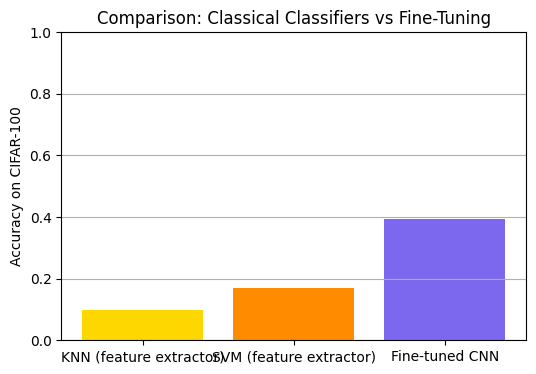

In [15]:
test_loss_ft, test_acc_ft, test_prec_ft = evaluate(
    ResCnn_model,
    test_loader_100,
    criterion,
    device
)

print("Baseline SVM:", svm_acc)
print("Baseline KNN:", knn_acc)
print("Fine-tuned model accuracy:", test_acc_ft)


# Comparison plot: KNN, SVM, Fine-tuned CNN
model_names = ["KNN (feature extractor)", "SVM (feature extractor)", "Fine-tuned CNN"]
accuracies = [knn_acc, svm_acc, test_acc_ft]

plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies, color=["gold", "darkorange", "mediumslateblue"]) 

# Set y-axis limits between 0 and 1
plt.ylim(0, 1)

# Label for the y-axis
plt.ylabel("Accuracy on CIFAR-100")

# Title of the plot
plt.title("Comparison: Classical Classifiers vs Fine-Tuning")

# Show horizontal grid lines
plt.grid(axis='y')

# Display the plot
plt.show()

